# Simulacao leitos - camas limitadas

In [498]:
# Import required modules

import simpy
import random
from random import expovariate, seed
import pandas as pd
import matplotlib.pyplot as plt

In [499]:
class g:
    """g holds Global variables. No individual instance is required"""
    
    cases_arriving = 40
    inter_arrival_time = 1/cases_arriving  # Average time (days) between arrivals
    los = 13  # Average length of stay in hospital (days)
    los_uti = 5  # Average length of stay in hospital (days)
    sim_duration = 360  # Duration of simulation (days)
    audit_interval = 1  # Interval between audits (days)
    total_beds = 300
    total_beds_icu = 100
    occupation_rate = 0.5
    icu_occupation_rate = 0.8
    icu_rate = 0.2
    beds = int(total_beds * (1 - occupation_rate))  # bed capacity of hospital
    icu_beds = int(total_beds_icu * (1 - icu_occupation_rate))

In [500]:
class Hospital:
    """
    Hospital class holds:
    1) Dictionary of patients present
    2) List of audit times
    3) List of beds occupied at each audit time
    4) Current total beds occupied
    5) Current total icu beds occupied
    6) Admissions to data

    Methods:

    __init__: Set up hospital instance

    audit: records number of beds occupied

    build_audit_report: builds audit report at end of run (calculate 5th, 50th
    and 95th percentile bed occupancy.

    chart: plot beds occupied over time (at end of run)
    """

    def __init__(self):
        """
        Constructor method for hospital class"
        Initialise object with attributes.
        """

        self.patients = {}  # Dictionary of patients present
        self.patients_in_queue = {}
        self.patients_in_icu_queue = {}
        
        self.patients_in_beds = {}
        self.patients_in_icu_beds = {}
        
        self.audit_time = []  # List of audit times
        self.audit_beds = []  # List of beds occupied at each audit time
        self.audit_icu_beds = []  # List of icu beds occupied at each audit time
        self.audit_queue = []
        self.audit_queue_icu = []
        
        self.bed_count = 0  # Current total beds occupied
        self.bed_icu_count = 0
        self.queue_count = 0
        self.queue_count_icu = 0
        self.admissions = 0  # Admissions to data
        
        return

    def audit(self, time):
        """
        Audit method. When called appends current simulation time to audit_time
        list, and appends current bed count to audit_beds.
        """
        self.audit_time.append(time)
        self.audit_beds.append(self.bed_count)
        self.audit_icu_beds.append(self.bed_icu_count)
        self.audit_queue.append(self.queue_count)
        self.audit_queue_icu.append(self.queue_count_icu)
        
        return

    def build_audit_report(self):
        """
        This method is called at end of run. It creates a pandas DataFrame,
        transfers audit times and bed counts to the DataFrame, and 
        calculates/stores 5th, 50th and 95th percentiles.
        """
        self.audit_report = pd.DataFrame()

        self.audit_report['Time'] = self.audit_time

        self.audit_report['Occupied_beds'] = self.audit_beds
        
        self.audit_report['ICU_Occupied_beds'] = self.audit_icu_beds

        self.audit_report['Median_beds'] = \
            self.audit_report['Occupied_beds'].quantile(0.5)
        
        self.audit_report['ICU_Median_beds'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.5)

        self.audit_report['Beds_5_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.05)

        self.audit_report['ICU_Beds_5_percent'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.05)
        
        self.audit_report['Beds_95_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.95)
        
        self.audit_report['ICU_Beds_95_percent'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.95)

        self.audit_report['Queue'] = self.audit_queue

        self.audit_report['Median_queue'] = \
            self.audit_report['Queue'].quantile(0.5)

        self.audit_report['Queue_5_percent'] = \
            self.audit_report['Queue'].quantile(0.05)

        self.audit_report['Queue_95_percent'] = \
            self.audit_report['Queue'].quantile(0.95)
        
        self.audit_report['ICU_Queue'] = self.audit_queue_icu

        self.audit_report['ICU_Median_queue'] = \
            self.audit_report['ICU_Queue'].quantile(0.5)

        self.audit_report['ICU_Queue_5_percent'] = \
            self.audit_report['ICU_Queue'].quantile(0.05)

        self.audit_report['ICU_Queue_95_percent'] = \
            self.audit_report['ICU_Queue'].quantile(0.95)

        return self.audit_report

    def chart(self):
        """
        This method is called at end of run. It plots beds occupancy over the
        model run, with 5%, 50% and 95% percentiles.
        """

        # Plot occupied beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Occupied beds')
        plt.title(
            'Occupied beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()
        
        
        # Plot occupied icu beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied icu beds')
        
        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')
        
        plt.xlabel('Day')
        plt.ylabel('Occupied icu beds')
        plt.title(
            'Occupied icu beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()
        

        # Plot queue for beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1, label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_queue'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Queue for beds')
        plt.title('Queue for beds (individual days with 5th, 50th and 95th' +
                  ' percentiles)')
        plt.legend()
        plt.show()
        
        
        # Plot queue for icu beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Queue'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1, label='ICU Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Queue_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Median_queue'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Queue_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('ICU Queue for beds')
        plt.title('ICU Queue for beds (individual days with 5th, 50th and 95th' +
                  ' percentiles)')
        plt.legend()
        plt.show()

        return

In [501]:
class Model:
    """
    The main model class.

    The model class contains the model environment. The modelling environment
    is set up, and patient arrival and audit processes initiated. Patient
    arrival triggers a spell for that patient in hospital. Arrivals and audit
    continue for the duration of the model run. The audit is then 
    summarised and bed occupancy (with 5th, 50th and 95th percentiles) plotted.

    Methods are:

    __init__: Set up model instance

    audit_beds: call for bed audit at regular intervals (after initial delay 
    for model warm-up)

    new_admission: trigger new admissions to hospital at regular intervals.
    Call for patient generation with patient id and length of stay, then call
    for patient spell in hospital.

    run: Controls the main model run. Initialises model and patient arrival and
    audit processes. Instigates the run. At end of run calls for an audit
    summary and bed occupancy plot.

    spell_gen: stores patient in hospital patient list and bed queue 
    dictionaries, waits for bed resource to become available, then removes 
    patient from bed queue dictionary and adds patient to hospital bed 
    dictionary and increments beds occupied. Waits for the patient length of
    stay in the hospital and then decrements beds occupied and removes patient
    from hospital patient dictionary and beds occupied dictionary.
    """

    def __init__(self):
        """
        Constructor class for new model.
        """
        self.env = simpy.Environment()

        return

    def audit_beds(self, delay):
        """
        Bed audit process. Begins by applying delay, then calls for audit at
        intervals set in g.audit_interval

        :param delay: delay (days) at start of model run for model warm-up.
        """

        # Delay first audit
        yield self.env.timeout(delay)

        # Continually generate audit requests until end of model run
        while True:
            # Call audit (pass simulation time to hospital.audit)
            self.hospital.audit(self.env.now)
            # Delay until next call
            yield self.env.timeout(g.audit_interval)

        return

    def new_admission(self, interarrival_time, los, los_uti):
        """
        New admissions to hospital.

        :param interarrival_time: average time (days) between arrivals
        :param los: average length of stay (days)
        """
        while True:
            # Increment hospital admissions count
            self.hospital.admissions += 1

            # Generate new patient object (from Patient class). Give patient id
            # and set length of stay from inverse exponential distribution).
            p = Patient(patient_id=self.hospital.admissions,
                        los=random.expovariate(1 / los),
                        los_uti=random.expovariate(1 / los_uti))
            print('Patient %d arriving %7.2f, admissions count %d' %(p.id,self.env.now,self.hospital.admissions))

            # Add patient to hospital patient dictionary
            self.hospital.patients[p.id] = p

            # Generate a patient spell in hospital (by calling spell method).
            # This triggers a patient admission and allows the next arrival to
            # be set before the paitent spell is finished
            self.spell = self.spell_gen(p)
            self.env.process(self.spell)

            # Set and call delay before looping back to new patient admission
            next_admission = random.expovariate(1 / interarrival_time)
            #print('Next patient in %f3.2' %next_admission)
            yield self.env.timeout(next_admission)

        return

    def spell_gen(self, p):
        """
        Patient hospital stay generator. Increment bed count, wait for patient
        length of stay to complete, then decrement bed count and remove patient
        from hospital patient dictionary

        :param p: patient object (contains length of stay for patient)
        """
        # The following 'with' defines the required resources and automatically
        # releases resources when no longer required

        with self.resources.beds.request() as req:
            # Increment queue count
            self.hospital.queue_count += 1
            print('Patient %d arriving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

            # Add patient to dictionary of queuing patients. This is not used
            # further in this model.
            self.hospital.patients_in_queue[p.id] = p

            # Yield resource request. Sim continues after yield when resources
            # are vailable (so there is no delay if resources are immediately
            # available)
            yield req

            # Resource now available. Remove from queue count and dictionary of
            # queued objects
            self.hospital.queue_count -= 1
            del self.hospital.patients_in_queue[p.id]
            print('Patient %d leaving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

            # Add to count of patients in beds and to dictionary of patients in
            # beds
            self.hospital.patients_in_beds[p.id] = p
            self.hospital.bed_count += 1
            print('Patient %d arriving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))

            # Trigger length of stay delay
            yield self.env.timeout(p.los)

            # Length of stay complete. Remove patient from counts and
            # dictionaries
            self.hospital.bed_count -= 1
            print('Patient %d leaving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))
            del self.hospital.patients_in_beds[p.id]
        
        is_icu = 1 if random.uniform(0, 1) > (1-g.icu_rate) else 0
        
        if is_icu == 1:
            
            with self.resources_icu.icu_beds.request() as icu_req:
                
                # Increment queue count
                self.hospital.queue_count_icu += 1
                print('Patient %d arriving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))
                
                # Add patient to dictionary of icu queuing patients. This is not used
                # further in this model.
                self.hospital.patients_in_icu_queue[p.id] = p
                
                # Yield resource request. Sim continues after yield when resources
                # are vailable (so there is no delay if resources are immediately
                # available)
                yield icu_req
                
                # Resource now available. Remove from queue count and dictionary of
                # queued objects
                self.hospital.queue_count_icu -= 1
                del self.hospital.patients_in_icu_queue[p.id]
                print('Patient %d leaving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))
                
                # Add to count of patients in icu beds and to dictionary of patients in
                # icu beds
                self.hospital.patients_in_icu_beds[p.id] = p
                self.hospital.bed_icu_count += 1
                print('Patient %d arriving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                
                # Trigger length of stay delay
                yield self.env.timeout(p.los_uti)
                
                # Length of stay complete. Remove patient from counts and
                # dictionaries
                self.hospital.bed_icu_count -= 1
                print('Patient %d leaving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                del self.hospital.patients_in_icu_beds[p.id]
                del self.hospital.patients[p.id]

        return
    
    def run(self):
        """
        Controls the main model run. Initialises model and patient arrival and
        audit processes. Instigates the run. At end of run calls for an audit
        summary and bed occupancy plot
        """

        # Set up hospital (calling Hospital class)
        self.hospital = Hospital()

        # Set up resources (beds, icu_beds)
        self.resources = Resources(self.env, g.beds)
        self.resources_icu = Resources_ICU(self.env, g.icu_beds)

        # Set up starting processes: new admissions and bed  audit (with delay)
        self.env.process(self.new_admission(g.inter_arrival_time, g.los, g.los_uti))
        self.env.process(self.audit_beds(delay=20))

        # Start model run
        self.env.run(until=g.sim_duration)

        # At end of run call for bed audit summary and bed occupancy plot
        self.hospital.build_audit_report()
        #self.hospital.chart()

        return

In [502]:
class Patient:
    """
    Patient class. Contains patient id and length of stay (it could contain
    other info about patient, such as priority or clinical group.

    The only method is __init__ for creating a patient (with assignment of
    patient id and length of stay).
    """

    def __init__(self, patient_id, los, los_uti):
        """
        Contructor for new patient.

        :param patient_id: id of patient  (set in self.new_admission)
        :param los: length of stay (days, set in self.new_admission)
        """
        self.id = patient_id
        self.los = los
        self.los_uti = los_uti

        return

In [503]:
class Resources:
    """
    Holds beds resources
    """

    def __init__(self, env, number_of_beds):
        """        Constructor method to initialise beds resource)"""
        self.beds = simpy.Resource(env, capacity=number_of_beds)

        return

In [504]:
class Resources_ICU:
    """
    Holds icu beds resources
    """

    def __init__(self, env, number_of_icu_beds):
        """        Constructor method to initialise icu beds resource)"""
        self.icu_beds = simpy.Resource(env, capacity=number_of_icu_beds)

        return

In [505]:
def main():
    """
    Code entry point after: if __name__ == '__main__'
    Creates model object, and runs model
    """

    model = Model()
    model.run()

    return

In [506]:
## Code entry point. Calls main method.
#if __name__ == '__main__':
#    main()

In [507]:
(random.uniform(0, 1) * 10) / 300

0.02545894804462391

In [522]:
(random.uniform(0, 1) * 40)

0.0010771008051166377

In [508]:
jow = []
for i in range(10):
    j = 1 if random.uniform(0, 1) > (1-0.7)  else 0
    jow.append(j)
    print(j, sum(jow) )

1 1
1 2
1 3
0 3
1 4
1 5
1 6
1 7
1 8
1 9


In [525]:
random.sample(range(1, 100), 3)

[3, 27, 51]

In [509]:
1/10

0.1

In [679]:
z = [1 if random.uniform(0, 1) > (1-0.2)  else 0 for i in range(40)]
f = random.sample(z, 1)
if f == 1:
    print(f)

In [721]:
random.sample(z, 1)

[0]

In [510]:
model = Model()

In [511]:
%%time
seed(98989)
model.run()

Patient 1 arriving    0.00, admissions count 1
Patient 1 arriving queue    0.00, queue count 1
Patient 1 leaving queue    0.00, queue count 0
Patient 1 arriving bed    0.00, bed count 1
Patient 2 arriving    0.01, admissions count 2
Patient 2 arriving queue    0.01, queue count 1
Patient 2 leaving queue    0.01, queue count 0
Patient 2 arriving bed    0.01, bed count 2
Patient 3 arriving    0.02, admissions count 3
Patient 3 arriving queue    0.02, queue count 1
Patient 3 leaving queue    0.02, queue count 0
Patient 3 arriving bed    0.02, bed count 3
Patient 4 arriving    0.06, admissions count 4
Patient 4 arriving queue    0.06, queue count 1
Patient 4 leaving queue    0.06, queue count 0
Patient 4 arriving bed    0.06, bed count 4
Patient 5 arriving    0.07, admissions count 5
Patient 5 arriving queue    0.07, queue count 1
Patient 5 leaving queue    0.07, queue count 0
Patient 5 arriving bed    0.07, bed count 5
Patient 6 arriving    0.08, admissions count 6
Patient 6 arriving queu

Patient 175 arriving bed    4.74, bed count 139
Patient 176 arriving    4.76, admissions count 176
Patient 176 arriving queue    4.76, queue count 1
Patient 176 leaving queue    4.76, queue count 0
Patient 176 arriving bed    4.76, bed count 140
Patient 177 arriving    4.77, admissions count 177
Patient 177 arriving queue    4.77, queue count 1
Patient 177 leaving queue    4.77, queue count 0
Patient 177 arriving bed    4.77, bed count 141
Patient 178 arriving    4.77, admissions count 178
Patient 178 arriving queue    4.77, queue count 1
Patient 178 leaving queue    4.77, queue count 0
Patient 178 arriving bed    4.77, bed count 142
Patient 30 leaving bed    4.80, bed count 141
Patient 179 arriving    4.81, admissions count 179
Patient 179 arriving queue    4.81, queue count 1
Patient 179 leaving queue    4.81, queue count 0
Patient 179 arriving bed    4.81, bed count 142
Patient 180 arriving    4.83, admissions count 180
Patient 180 arriving queue    4.83, queue count 1
Patient 180 l

Patient 228 arriving    6.05, admissions count 228
Patient 228 arriving queue    6.05, queue count 22
Patient 229 arriving    6.06, admissions count 229
Patient 229 arriving queue    6.06, queue count 23
Patient 230 arriving    6.07, admissions count 230
Patient 230 arriving queue    6.07, queue count 24
Patient 231 arriving    6.09, admissions count 231
Patient 231 arriving queue    6.09, queue count 25
Patient 232 arriving    6.12, admissions count 232
Patient 232 arriving queue    6.12, queue count 26
Patient 233 arriving    6.14, admissions count 233
Patient 233 arriving queue    6.14, queue count 27
Patient 234 arriving    6.15, admissions count 234
Patient 234 arriving queue    6.15, queue count 28
Patient 235 arriving    6.16, admissions count 235
Patient 235 arriving queue    6.16, queue count 29
Patient 236 arriving    6.27, admissions count 236
Patient 236 arriving queue    6.27, queue count 30
Patient 131 leaving bed    6.30, bed count 149
Patient 207 leaving queue    6.30, 

Patient 132 arriving queue   10.58, queue count 138
Patient 132 leaving queue   10.58, queue count 138
Patient 132 arriving icu bed   10.58, icu bed count 9
Patient 268 leaving queue   10.58, queue count 137
Patient 268 arriving bed   10.58, bed count 150
Patient 406 arriving   10.59, admissions count 406
Patient 406 arriving queue   10.59, queue count 138
Patient 185 leaving bed   10.61, bed count 149
Patient 185 arriving queue   10.61, queue count 138
Patient 185 leaving queue   10.61, queue count 138
Patient 185 arriving icu bed   10.61, icu bed count 10
Patient 269 leaving queue   10.61, queue count 137
Patient 269 arriving bed   10.61, bed count 150
Patient 407 arriving   10.63, admissions count 407
Patient 407 arriving queue   10.63, queue count 138
Patient 408 arriving   10.64, admissions count 408
Patient 408 arriving queue   10.64, queue count 139
Patient 258 leaving bed   10.65, bed count 149
Patient 258 arriving queue   10.65, queue count 139
Patient 258 leaving queue   10.6

Patient 622 arriving   16.10, admissions count 622
Patient 622 arriving queue   16.10, queue count 274
Patient 623 arriving   16.10, admissions count 623
Patient 623 arriving queue   16.10, queue count 275
Patient 624 arriving   16.12, admissions count 624
Patient 624 arriving queue   16.12, queue count 276
Patient 625 arriving   16.12, admissions count 625
Patient 625 arriving queue   16.12, queue count 277
Patient 340 leaving bed   16.14, bed count 149
Patient 340 arriving queue   16.14, queue count 277
Patient 340 leaving queue   16.14, queue count 277
Patient 340 arriving icu bed   16.14, icu bed count 14
Patient 349 leaving queue   16.14, queue count 276
Patient 349 arriving bed   16.14, bed count 150
Patient 626 arriving   16.16, admissions count 626
Patient 626 arriving queue   16.16, queue count 277
Patient 627 arriving   16.17, admissions count 627
Patient 627 arriving queue   16.17, queue count 278
Patient 340 leaving icu bed   16.20, icu bed count 13
Patient 628 arriving   1

Patient 411 arriving bed   22.10, bed count 150
Patient 898 arriving   22.12, admissions count 898
Patient 898 arriving queue   22.12, queue count 487
Patient 899 arriving   22.13, admissions count 899
Patient 899 arriving queue   22.13, queue count 488
Patient 900 arriving   22.13, admissions count 900
Patient 900 arriving queue   22.13, queue count 489
Patient 901 arriving   22.14, admissions count 901
Patient 901 arriving queue   22.14, queue count 490
Patient 124 leaving bed   22.15, bed count 149
Patient 124 arriving queue   22.15, queue count 490
Patient 124 leaving queue   22.15, queue count 490
Patient 124 arriving icu bed   22.15, icu bed count 13
Patient 412 leaving queue   22.15, queue count 489
Patient 412 arriving bed   22.15, bed count 150
Patient 296 leaving bed   22.16, bed count 149
Patient 413 leaving queue   22.16, queue count 488
Patient 413 arriving bed   22.16, bed count 150
Patient 902 arriving   22.18, admissions count 902
Patient 902 arriving queue   22.18, que

Patient 1112 arriving queue   28.41, queue count 628
Patient 1113 arriving   28.47, admissions count 1113
Patient 1113 arriving queue   28.47, queue count 629
Patient 1114 arriving   28.52, admissions count 1114
Patient 1114 arriving queue   28.52, queue count 630
Patient 440 leaving bed   28.54, bed count 149
Patient 485 leaving queue   28.54, queue count 629
Patient 485 arriving bed   28.54, bed count 150
Patient 1115 arriving   28.54, admissions count 1115
Patient 1115 arriving queue   28.54, queue count 630
Patient 1116 arriving   28.57, admissions count 1116
Patient 1116 arriving queue   28.57, queue count 631
Patient 1117 arriving   28.64, admissions count 1117
Patient 1117 arriving queue   28.64, queue count 632
Patient 407 leaving bed   28.66, bed count 149
Patient 486 leaving queue   28.66, queue count 631
Patient 486 arriving bed   28.66, bed count 150
Patient 1118 arriving   28.70, admissions count 1118
Patient 1118 arriving queue   28.70, queue count 632
Patient 229 leaving

Patient 1274 arriving queue   32.91, queue count 734
Patient 531 leaving bed   32.95, bed count 149
Patient 541 leaving queue   32.95, queue count 733
Patient 541 arriving bed   32.95, bed count 150
Patient 506 leaving bed   32.96, bed count 149
Patient 542 leaving queue   32.96, queue count 732
Patient 542 arriving bed   32.96, bed count 150
Patient 1275 arriving   32.96, admissions count 1275
Patient 1275 arriving queue   32.96, queue count 733
Patient 1276 arriving   32.97, admissions count 1276
Patient 1276 arriving queue   32.97, queue count 734
Patient 1277 arriving   32.97, admissions count 1277
Patient 1277 arriving queue   32.97, queue count 735
Patient 1278 arriving   32.98, admissions count 1278
Patient 1278 arriving queue   32.98, queue count 736
Patient 1279 arriving   33.02, admissions count 1279
Patient 1279 arriving queue   33.02, queue count 737
Patient 1280 arriving   33.07, admissions count 1280
Patient 1280 arriving queue   33.07, queue count 738
Patient 1281 arrivi

Patient 1534 arriving   39.63, admissions count 1534
Patient 1534 arriving queue   39.63, queue count 925
Patient 1535 arriving   39.64, admissions count 1535
Patient 1535 arriving queue   39.64, queue count 926
Patient 1536 arriving   39.65, admissions count 1536
Patient 1536 arriving queue   39.65, queue count 927
Patient 1537 arriving   39.66, admissions count 1537
Patient 1537 arriving queue   39.66, queue count 928
Patient 1538 arriving   39.67, admissions count 1538
Patient 1538 arriving queue   39.67, queue count 929
Patient 1539 arriving   39.69, admissions count 1539
Patient 1539 arriving queue   39.69, queue count 930
Patient 549 leaving bed   39.70, bed count 149
Patient 610 leaving queue   39.70, queue count 929
Patient 610 arriving bed   39.70, bed count 150
Patient 303 leaving bed   39.72, bed count 149
Patient 303 arriving queue   39.72, queue count 929
Patient 303 leaving queue   39.72, queue count 929
Patient 303 arriving icu bed   39.72, icu bed count 11
Patient 611 l

Patient 672 arriving bed   45.34, bed count 150
Patient 541 leaving bed   45.35, bed count 149
Patient 673 leaving queue   45.35, queue count 1082
Patient 673 arriving bed   45.35, bed count 150
Patient 499 leaving bed   45.35, bed count 149
Patient 674 leaving queue   45.35, queue count 1081
Patient 674 arriving bed   45.35, bed count 150
Patient 1756 arriving   45.35, admissions count 1756
Patient 1756 arriving queue   45.35, queue count 1082
Patient 1757 arriving   45.41, admissions count 1757
Patient 1757 arriving queue   45.41, queue count 1083
Patient 616 leaving bed   45.43, bed count 149
Patient 675 leaving queue   45.43, queue count 1082
Patient 675 arriving bed   45.43, bed count 150
Patient 1758 arriving   45.43, admissions count 1758
Patient 1758 arriving queue   45.43, queue count 1083
Patient 1759 arriving   45.44, admissions count 1759
Patient 1759 arriving queue   45.44, queue count 1084
Patient 666 leaving bed   45.45, bed count 149
Patient 666 arriving queue   45.45, 

Patient 2067 arriving   52.92, admissions count 2067
Patient 2067 arriving queue   52.92, queue count 1303
Patient 2068 arriving   52.96, admissions count 2068
Patient 2068 arriving queue   52.96, queue count 1304
Patient 2069 arriving   52.96, admissions count 2069
Patient 2069 arriving queue   52.96, queue count 1305
Patient 2070 arriving   53.02, admissions count 2070
Patient 2070 arriving queue   53.02, queue count 1306
Patient 2071 arriving   53.03, admissions count 2071
Patient 2071 arriving queue   53.03, queue count 1307
Patient 2072 arriving   53.08, admissions count 2072
Patient 2072 arriving queue   53.08, queue count 1308
Patient 2073 arriving   53.12, admissions count 2073
Patient 2073 arriving queue   53.12, queue count 1309
Patient 2074 arriving   53.14, admissions count 2074
Patient 2074 arriving queue   53.14, queue count 1310
Patient 2075 arriving   53.15, admissions count 2075
Patient 2075 arriving queue   53.15, queue count 1311
Patient 2076 arriving   53.18, admiss

Patient 2238 arriving queue   57.40, queue count 1424
Patient 633 leaving bed   57.43, bed count 149
Patient 815 leaving queue   57.43, queue count 1423
Patient 815 arriving bed   57.43, bed count 150
Patient 2239 arriving   57.47, admissions count 2239
Patient 2239 arriving queue   57.47, queue count 1424
Patient 2240 arriving   57.47, admissions count 2240
Patient 2240 arriving queue   57.47, queue count 1425
Patient 2241 arriving   57.51, admissions count 2241
Patient 2241 arriving queue   57.51, queue count 1426
Patient 645 leaving icu bed   57.51, icu bed count 15
Patient 2242 arriving   57.55, admissions count 2242
Patient 2242 arriving queue   57.55, queue count 1427
Patient 797 leaving bed   57.57, bed count 149
Patient 816 leaving queue   57.57, queue count 1426
Patient 816 arriving bed   57.57, bed count 150
Patient 2243 arriving   57.57, admissions count 2243
Patient 2243 arriving queue   57.57, queue count 1427
Patient 2244 arriving   57.59, admissions count 2244
Patient 22

Patient 2411 arriving   61.32, admissions count 2411
Patient 2411 arriving queue   61.32, queue count 1551
Patient 2412 arriving   61.33, admissions count 2412
Patient 2412 arriving queue   61.33, queue count 1552
Patient 2413 arriving   61.35, admissions count 2413
Patient 2413 arriving queue   61.35, queue count 1553
Patient 631 leaving bed   61.41, bed count 149
Patient 631 arriving queue   61.41, queue count 1553
Patient 631 leaving queue   61.41, queue count 1553
Patient 631 arriving icu bed   61.41, icu bed count 16
Patient 861 leaving queue   61.41, queue count 1552
Patient 861 arriving bed   61.41, bed count 150
Patient 2414 arriving   61.41, admissions count 2414
Patient 2414 arriving queue   61.41, queue count 1553
Patient 2415 arriving   61.45, admissions count 2415
Patient 2415 arriving queue   61.45, queue count 1554
Patient 2416 arriving   61.46, admissions count 2416
Patient 2416 arriving queue   61.46, queue count 1555
Patient 785 leaving bed   61.48, bed count 149
Pati

Patient 2710 arriving queue   69.65, queue count 1754
Patient 2711 arriving   69.72, admissions count 2711
Patient 2711 arriving queue   69.72, queue count 1755
Patient 2712 arriving   69.73, admissions count 2712
Patient 2712 arriving queue   69.73, queue count 1756
Patient 2713 arriving   69.74, admissions count 2713
Patient 2713 arriving queue   69.74, queue count 1757
Patient 2714 arriving   69.75, admissions count 2714
Patient 2714 arriving queue   69.75, queue count 1758
Patient 2715 arriving   69.77, admissions count 2715
Patient 2715 arriving queue   69.77, queue count 1759
Patient 2716 arriving   69.85, admissions count 2716
Patient 2716 arriving queue   69.85, queue count 1760
Patient 821 leaving bed   69.86, bed count 149
Patient 957 leaving queue   69.86, queue count 1759
Patient 957 arriving bed   69.86, bed count 150
Patient 2717 arriving   69.87, admissions count 2717
Patient 2717 arriving queue   69.87, queue count 1760
Patient 2718 arriving   69.89, admissions count 27

Patient 939 leaving bed   73.61, bed count 149
Patient 999 leaving queue   73.61, queue count 1883
Patient 999 arriving bed   73.61, bed count 150
Patient 2883 arriving   73.61, admissions count 2883
Patient 2883 arriving queue   73.61, queue count 1884
Patient 2884 arriving   73.62, admissions count 2884
Patient 2884 arriving queue   73.62, queue count 1885
Patient 2885 arriving   73.62, admissions count 2885
Patient 2885 arriving queue   73.62, queue count 1886
Patient 811 leaving icu bed   73.66, icu bed count 13
Patient 2886 arriving   73.67, admissions count 2886
Patient 2886 arriving queue   73.67, queue count 1887
Patient 2887 arriving   73.74, admissions count 2887
Patient 2887 arriving queue   73.74, queue count 1888
Patient 2888 arriving   73.82, admissions count 2888
Patient 2888 arriving queue   73.82, queue count 1889
Patient 951 leaving icu bed   73.83, icu bed count 12
Patient 735 leaving bed   73.85, bed count 149
Patient 1000 leaving queue   73.85, queue count 1888
Pat

Patient 3042 arriving   77.40, admissions count 3042
Patient 3042 arriving queue   77.40, queue count 1998
Patient 3043 arriving   77.41, admissions count 3043
Patient 3043 arriving queue   77.41, queue count 1999
Patient 3044 arriving   77.42, admissions count 3044
Patient 3044 arriving queue   77.42, queue count 2000
Patient 3045 arriving   77.45, admissions count 3045
Patient 3045 arriving queue   77.45, queue count 2001
Patient 3046 arriving   77.46, admissions count 3046
Patient 3046 arriving queue   77.46, queue count 2002
Patient 3047 arriving   77.47, admissions count 3047
Patient 3047 arriving queue   77.47, queue count 2003
Patient 3048 arriving   77.48, admissions count 3048
Patient 3048 arriving queue   77.48, queue count 2004
Patient 983 leaving bed   77.51, bed count 149
Patient 1045 leaving queue   77.51, queue count 2003
Patient 1045 arriving bed   77.51, bed count 150
Patient 999 leaving bed   77.54, bed count 149
Patient 1046 leaving queue   77.54, queue count 2002
Pa

Patient 783 arriving queue   84.35, queue count 2195
Patient 783 leaving queue   84.35, queue count 2195
Patient 783 arriving icu bed   84.35, icu bed count 10
Patient 1130 leaving queue   84.35, queue count 2194
Patient 1130 arriving bed   84.35, bed count 150
Patient 1062 leaving bed   84.36, bed count 149
Patient 1131 leaving queue   84.36, queue count 2193
Patient 1131 arriving bed   84.36, bed count 150
Patient 3325 arriving   84.36, admissions count 3325
Patient 3325 arriving queue   84.36, queue count 2194
Patient 3326 arriving   84.37, admissions count 3326
Patient 3326 arriving queue   84.37, queue count 2195
Patient 3327 arriving   84.37, admissions count 3327
Patient 3327 arriving queue   84.37, queue count 2196
Patient 3328 arriving   84.40, admissions count 3328
Patient 3328 arriving queue   84.40, queue count 2197
Patient 3329 arriving   84.41, admissions count 3329
Patient 3329 arriving queue   84.41, queue count 2198
Patient 3330 arriving   84.44, admissions count 3330


Patient 1026 leaving bed   89.08, bed count 149
Patient 1186 leaving queue   89.08, queue count 2332
Patient 1186 arriving bed   89.08, bed count 150
Patient 3519 arriving   89.08, admissions count 3519
Patient 3519 arriving queue   89.08, queue count 2333
Patient 3520 arriving   89.08, admissions count 3520
Patient 3520 arriving queue   89.08, queue count 2334
Patient 3521 arriving   89.11, admissions count 3521
Patient 3521 arriving queue   89.11, queue count 2335
Patient 3522 arriving   89.13, admissions count 3522
Patient 3522 arriving queue   89.13, queue count 2336
Patient 1083 leaving bed   89.13, bed count 149
Patient 1187 leaving queue   89.13, queue count 2335
Patient 1187 arriving bed   89.13, bed count 150
Patient 932 leaving bed   89.15, bed count 149
Patient 1188 leaving queue   89.15, queue count 2334
Patient 1188 arriving bed   89.15, bed count 150
Patient 3523 arriving   89.15, admissions count 3523
Patient 3523 arriving queue   89.15, queue count 2335
Patient 3524 arr

Patient 1022 leaving bed   95.97, bed count 149
Patient 1267 leaving queue   95.97, queue count 2549
Patient 1267 arriving bed   95.97, bed count 150
Patient 1180 leaving bed   95.98, bed count 149
Patient 1268 leaving queue   95.98, queue count 2548
Patient 1268 arriving bed   95.98, bed count 150
Patient 3817 arriving   95.98, admissions count 3817
Patient 3817 arriving queue   95.98, queue count 2549
Patient 3818 arriving   95.99, admissions count 3818
Patient 3818 arriving queue   95.99, queue count 2550
Patient 3819 arriving   96.02, admissions count 3819
Patient 3819 arriving queue   96.02, queue count 2551
Patient 876 leaving icu bed   96.02, icu bed count 8
Patient 3820 arriving   96.06, admissions count 3820
Patient 3820 arriving queue   96.06, queue count 2552
Patient 1248 leaving bed   96.06, bed count 149
Patient 1248 arriving queue   96.06, queue count 2552
Patient 1248 leaving queue   96.06, queue count 2552
Patient 1248 arriving icu bed   96.06, icu bed count 9
Patient 1

Patient 4011 arriving  101.29, admissions count 4011
Patient 4011 arriving queue  101.29, queue count 2688
Patient 4012 arriving  101.39, admissions count 4012
Patient 4012 arriving queue  101.39, queue count 2689
Patient 4013 arriving  101.40, admissions count 4013
Patient 4013 arriving queue  101.40, queue count 2690
Patient 4014 arriving  101.44, admissions count 4014
Patient 4014 arriving queue  101.44, queue count 2691
Patient 4015 arriving  101.45, admissions count 4015
Patient 4015 arriving queue  101.45, queue count 2692
Patient 4016 arriving  101.46, admissions count 4016
Patient 4016 arriving queue  101.46, queue count 2693
Patient 4017 arriving  101.46, admissions count 4017
Patient 4017 arriving queue  101.46, queue count 2694
Patient 4018 arriving  101.54, admissions count 4018
Patient 4018 arriving queue  101.54, queue count 2695
Patient 4019 arriving  101.55, admissions count 4019
Patient 4019 arriving queue  101.55, queue count 2696
Patient 4020 arriving  101.55, admiss

Patient 4291 arriving queue  108.24, queue count 2879
Patient 1316 leaving bed  108.24, bed count 149
Patient 1413 leaving queue  108.24, queue count 2878
Patient 1413 arriving bed  108.24, bed count 150
Patient 4292 arriving  108.25, admissions count 4292
Patient 4292 arriving queue  108.25, queue count 2879
Patient 4293 arriving  108.25, admissions count 4293
Patient 4293 arriving queue  108.25, queue count 2880
Patient 4294 arriving  108.26, admissions count 4294
Patient 4294 arriving queue  108.26, queue count 2881
Patient 1041 leaving bed  108.27, bed count 149
Patient 1414 leaving queue  108.27, queue count 2880
Patient 1414 arriving bed  108.27, bed count 150
Patient 4295 arriving  108.28, admissions count 4295
Patient 4295 arriving queue  108.28, queue count 2881
Patient 4296 arriving  108.29, admissions count 4296
Patient 4296 arriving queue  108.29, queue count 2882
Patient 4297 arriving  108.30, admissions count 4297
Patient 4297 arriving queue  108.30, queue count 2883
Pati

Patient 4506 arriving queue  113.14, queue count 3042
Patient 4507 arriving  113.15, admissions count 4507
Patient 4507 arriving queue  113.15, queue count 3043
Patient 4508 arriving  113.15, admissions count 4508
Patient 4508 arriving queue  113.15, queue count 3044
Patient 4509 arriving  113.16, admissions count 4509
Patient 4509 arriving queue  113.16, queue count 3045
Patient 4510 arriving  113.17, admissions count 4510
Patient 4510 arriving queue  113.17, queue count 3046
Patient 4511 arriving  113.22, admissions count 4511
Patient 4511 arriving queue  113.22, queue count 3047
Patient 4512 arriving  113.24, admissions count 4512
Patient 4512 arriving queue  113.24, queue count 3048
Patient 4513 arriving  113.24, admissions count 4513
Patient 4513 arriving queue  113.24, queue count 3049
Patient 4514 arriving  113.27, admissions count 4514
Patient 4514 arriving queue  113.27, queue count 3050
Patient 4515 arriving  113.31, admissions count 4515
Patient 4515 arriving queue  113.31, 

Patient 1555 leaving queue  120.87, queue count 3281
Patient 1555 arriving bed  120.87, bed count 150
Patient 4837 arriving  120.87, admissions count 4837
Patient 4837 arriving queue  120.87, queue count 3282
Patient 4838 arriving  120.89, admissions count 4838
Patient 4838 arriving queue  120.89, queue count 3283
Patient 4839 arriving  120.89, admissions count 4839
Patient 4839 arriving queue  120.89, queue count 3284
Patient 4840 arriving  120.91, admissions count 4840
Patient 4840 arriving queue  120.91, queue count 3285
Patient 4841 arriving  120.93, admissions count 4841
Patient 4841 arriving queue  120.93, queue count 3286
Patient 1555 leaving bed  120.93, bed count 149
Patient 1556 leaving queue  120.93, queue count 3285
Patient 1556 arriving bed  120.93, bed count 150
Patient 4842 arriving  120.94, admissions count 4842
Patient 4842 arriving queue  120.94, queue count 3286
Patient 4843 arriving  120.95, admissions count 4843
Patient 4843 arriving queue  120.95, queue count 3287

Patient 5075 arriving queue  126.99, queue count 3456
Patient 5076 arriving  127.01, admissions count 5076
Patient 5076 arriving queue  127.01, queue count 3457
Patient 5077 arriving  127.01, admissions count 5077
Patient 5077 arriving queue  127.01, queue count 3458
Patient 5078 arriving  127.02, admissions count 5078
Patient 5078 arriving queue  127.02, queue count 3459
Patient 1170 leaving bed  127.03, bed count 149
Patient 1620 leaving queue  127.03, queue count 3458
Patient 1620 arriving bed  127.03, bed count 150
Patient 1322 leaving bed  127.03, bed count 149
Patient 1621 leaving queue  127.03, queue count 3457
Patient 1621 arriving bed  127.03, bed count 150
Patient 5079 arriving  127.04, admissions count 5079
Patient 5079 arriving queue  127.04, queue count 3458
Patient 5080 arriving  127.06, admissions count 5080
Patient 5080 arriving queue  127.06, queue count 3459
Patient 5081 arriving  127.06, admissions count 5081
Patient 5081 arriving queue  127.06, queue count 3460
Pati

Patient 1697 leaving queue  132.93, queue count 3614
Patient 1697 arriving bed  132.93, bed count 150
Patient 1185 leaving icu bed  132.93, icu bed count 11
Patient 5312 arriving  132.93, admissions count 5312
Patient 5312 arriving queue  132.93, queue count 3615
Patient 5313 arriving  132.94, admissions count 5313
Patient 5313 arriving queue  132.94, queue count 3616
Patient 5314 arriving  132.95, admissions count 5314
Patient 5314 arriving queue  132.95, queue count 3617
Patient 5315 arriving  132.96, admissions count 5315
Patient 5315 arriving queue  132.96, queue count 3618
Patient 5316 arriving  133.00, admissions count 5316
Patient 5316 arriving queue  133.00, queue count 3619
Patient 5317 arriving  133.01, admissions count 5317
Patient 5317 arriving queue  133.01, queue count 3620
Patient 5318 arriving  133.01, admissions count 5318
Patient 5318 arriving queue  133.01, queue count 3621
Patient 1210 leaving icu bed  133.05, icu bed count 10
Patient 1690 leaving bed  133.08, bed c

Patient 5578 arriving  140.51, admissions count 5578
Patient 5578 arriving queue  140.51, queue count 3789
Patient 5579 arriving  140.52, admissions count 5579
Patient 5579 arriving queue  140.52, queue count 3790
Patient 5580 arriving  140.55, admissions count 5580
Patient 5580 arriving queue  140.55, queue count 3791
Patient 5581 arriving  140.56, admissions count 5581
Patient 5581 arriving queue  140.56, queue count 3792
Patient 1708 leaving bed  140.59, bed count 149
Patient 1790 leaving queue  140.59, queue count 3791
Patient 1790 arriving bed  140.59, bed count 150
Patient 1743 leaving bed  140.65, bed count 149
Patient 1791 leaving queue  140.65, queue count 3790
Patient 1791 arriving bed  140.65, bed count 150
Patient 1773 leaving bed  140.69, bed count 149
Patient 1792 leaving queue  140.69, queue count 3789
Patient 1792 arriving bed  140.69, bed count 150
Patient 5582 arriving  140.69, admissions count 5582
Patient 5582 arriving queue  140.69, queue count 3790
Patient 5583 ar

Patient 1848 leaving queue  145.28, queue count 3912
Patient 1848 arriving icu bed  145.28, icu bed count 13
Patient 1853 leaving queue  145.28, queue count 3911
Patient 1853 arriving bed  145.28, bed count 150
Patient 5765 arriving  145.35, admissions count 5765
Patient 5765 arriving queue  145.35, queue count 3912
Patient 5766 arriving  145.35, admissions count 5766
Patient 5766 arriving queue  145.35, queue count 3913
Patient 5767 arriving  145.36, admissions count 5767
Patient 5767 arriving queue  145.36, queue count 3914
Patient 5768 arriving  145.36, admissions count 5768
Patient 5768 arriving queue  145.36, queue count 3915
Patient 1839 leaving bed  145.37, bed count 149
Patient 1854 leaving queue  145.37, queue count 3914
Patient 1854 arriving bed  145.37, bed count 150
Patient 5769 arriving  145.39, admissions count 5769
Patient 5769 arriving queue  145.39, queue count 3915
Patient 5770 arriving  145.41, admissions count 5770
Patient 5770 arriving queue  145.41, queue count 39

Patient 6096 arriving  153.99, admissions count 6096
Patient 6096 arriving queue  153.99, queue count 4155
Patient 6097 arriving  153.99, admissions count 6097
Patient 6097 arriving queue  153.99, queue count 4156
Patient 6098 arriving  154.04, admissions count 6098
Patient 6098 arriving queue  154.04, queue count 4157
Patient 1712 leaving bed  154.04, bed count 149
Patient 1942 leaving queue  154.04, queue count 4156
Patient 1942 arriving bed  154.04, bed count 150
Patient 6099 arriving  154.09, admissions count 6099
Patient 6099 arriving queue  154.09, queue count 4157
Patient 1729 leaving bed  154.09, bed count 149
Patient 1729 arriving queue  154.09, queue count 4157
Patient 1729 leaving queue  154.09, queue count 4157
Patient 1729 arriving icu bed  154.09, icu bed count 9
Patient 1943 leaving queue  154.09, queue count 4156
Patient 1943 arriving bed  154.09, bed count 150
Patient 6100 arriving  154.10, admissions count 6100
Patient 6100 arriving queue  154.10, queue count 4157
Pat

Patient 6406 arriving queue  162.16, queue count 4374
Patient 6407 arriving  162.21, admissions count 6407
Patient 6407 arriving queue  162.21, queue count 4375
Patient 6408 arriving  162.22, admissions count 6408
Patient 6408 arriving queue  162.22, queue count 4376
Patient 6409 arriving  162.22, admissions count 6409
Patient 6409 arriving queue  162.22, queue count 4377
Patient 6410 arriving  162.27, admissions count 6410
Patient 6410 arriving queue  162.27, queue count 4378
Patient 6411 arriving  162.30, admissions count 6411
Patient 6411 arriving queue  162.30, queue count 4379
Patient 6412 arriving  162.30, admissions count 6412
Patient 6412 arriving queue  162.30, queue count 4380
Patient 1774 leaving icu bed  162.30, icu bed count 5
Patient 1934 leaving bed  162.32, bed count 149
Patient 2033 leaving queue  162.32, queue count 4379
Patient 2033 arriving bed  162.32, bed count 150
Patient 6413 arriving  162.33, admissions count 6413
Patient 6413 arriving queue  162.33, queue coun

Patient 2087 leaving queue  166.43, queue count 4495
Patient 2087 arriving bed  166.43, bed count 150
Patient 6583 arriving  166.43, admissions count 6583
Patient 6583 arriving queue  166.43, queue count 4496
Patient 6584 arriving  166.46, admissions count 6584
Patient 6584 arriving queue  166.46, queue count 4497
Patient 1906 leaving bed  166.49, bed count 149
Patient 2088 leaving queue  166.49, queue count 4496
Patient 2088 arriving bed  166.49, bed count 150
Patient 6585 arriving  166.49, admissions count 6585
Patient 6585 arriving queue  166.49, queue count 4497
Patient 6586 arriving  166.51, admissions count 6586
Patient 6586 arriving queue  166.51, queue count 4498
Patient 6587 arriving  166.55, admissions count 6587
Patient 6587 arriving queue  166.55, queue count 4499
Patient 1925 leaving icu bed  166.56, icu bed count 6
Patient 6588 arriving  166.57, admissions count 6588
Patient 6588 arriving queue  166.57, queue count 4500
Patient 2044 leaving bed  166.60, bed count 149
Pati

Patient 6892 arriving queue  174.52, queue count 4713
Patient 1881 leaving icu bed  174.53, icu bed count 15
Patient 2156 leaving bed  174.57, bed count 149
Patient 2180 leaving queue  174.57, queue count 4712
Patient 2180 arriving bed  174.57, bed count 150
Patient 6893 arriving  174.58, admissions count 6893
Patient 6893 arriving queue  174.58, queue count 4713
Patient 6894 arriving  174.59, admissions count 6894
Patient 6894 arriving queue  174.59, queue count 4714
Patient 1971 leaving bed  174.60, bed count 149
Patient 2181 leaving queue  174.60, queue count 4713
Patient 2181 arriving bed  174.60, bed count 150
Patient 6895 arriving  174.61, admissions count 6895
Patient 6895 arriving queue  174.61, queue count 4714
Patient 2105 leaving bed  174.63, bed count 149
Patient 2182 leaving queue  174.63, queue count 4713
Patient 2182 arriving bed  174.63, bed count 150
Patient 6896 arriving  174.66, admissions count 6896
Patient 6896 arriving queue  174.66, queue count 4714
Patient 6897 

Patient 7080 arriving  178.66, admissions count 7080
Patient 7080 arriving queue  178.66, queue count 4860
Patient 7081 arriving  178.66, admissions count 7081
Patient 7081 arriving queue  178.66, queue count 4861
Patient 2173 leaving bed  178.68, bed count 149
Patient 2221 leaving queue  178.68, queue count 4860
Patient 2221 arriving bed  178.68, bed count 150
Patient 7082 arriving  178.70, admissions count 7082
Patient 7082 arriving queue  178.70, queue count 4861
Patient 2195 leaving bed  178.71, bed count 149
Patient 2222 leaving queue  178.71, queue count 4860
Patient 2222 arriving bed  178.71, bed count 150
Patient 7083 arriving  178.72, admissions count 7083
Patient 7083 arriving queue  178.72, queue count 4861
Patient 2135 leaving bed  178.75, bed count 149
Patient 2223 leaving queue  178.75, queue count 4860
Patient 2223 arriving bed  178.75, bed count 150
Patient 2201 leaving bed  178.75, bed count 149
Patient 2201 arriving queue  178.75, queue count 4860
Patient 2201 leaving

Patient 7401 arriving queue  186.76, queue count 5088
Patient 7402 arriving  186.76, admissions count 7402
Patient 7402 arriving queue  186.76, queue count 5089
Patient 7403 arriving  186.81, admissions count 7403
Patient 7403 arriving queue  186.81, queue count 5090
Patient 7404 arriving  186.84, admissions count 7404
Patient 7404 arriving queue  186.84, queue count 5091
Patient 7405 arriving  186.84, admissions count 7405
Patient 7405 arriving queue  186.84, queue count 5092
Patient 2147 leaving icu bed  186.88, icu bed count 11
Patient 7406 arriving  186.88, admissions count 7406
Patient 7406 arriving queue  186.88, queue count 5093
Patient 7407 arriving  186.90, admissions count 7407
Patient 7407 arriving queue  186.90, queue count 5094
Patient 7408 arriving  186.92, admissions count 7408
Patient 7408 arriving queue  186.92, queue count 5095
Patient 7409 arriving  186.97, admissions count 7409
Patient 7409 arriving queue  186.97, queue count 5096
Patient 7410 arriving  186.99, admi

Patient 2004 leaving bed  190.76, bed count 149
Patient 2369 leaving queue  190.76, queue count 5176
Patient 2369 arriving bed  190.76, bed count 150
Patient 7546 arriving  190.79, admissions count 7546
Patient 7546 arriving queue  190.79, queue count 5177
Patient 7547 arriving  190.80, admissions count 7547
Patient 7547 arriving queue  190.80, queue count 5178
Patient 7548 arriving  190.85, admissions count 7548
Patient 7548 arriving queue  190.85, queue count 5179
Patient 7549 arriving  190.87, admissions count 7549
Patient 7549 arriving queue  190.87, queue count 5180
Patient 7550 arriving  190.88, admissions count 7550
Patient 7550 arriving queue  190.88, queue count 5181
Patient 7551 arriving  190.88, admissions count 7551
Patient 7551 arriving queue  190.88, queue count 5182
Patient 7552 arriving  190.88, admissions count 7552
Patient 7552 arriving queue  190.88, queue count 5183
Patient 7553 arriving  190.89, admissions count 7553
Patient 7553 arriving queue  190.89, queue count

Patient 7737 arriving queue  195.54, queue count 5313
Patient 2367 leaving bed  195.55, bed count 149
Patient 2367 arriving queue  195.55, queue count 5313
Patient 2367 leaving queue  195.55, queue count 5313
Patient 2367 arriving icu bed  195.55, icu bed count 13
Patient 2425 leaving queue  195.55, queue count 5312
Patient 2425 arriving bed  195.55, bed count 150
Patient 1973 leaving bed  195.55, bed count 149
Patient 2426 leaving queue  195.55, queue count 5311
Patient 2426 arriving bed  195.55, bed count 150
Patient 2053 leaving icu bed  195.56, icu bed count 12
Patient 7738 arriving  195.56, admissions count 7738
Patient 7738 arriving queue  195.56, queue count 5312
Patient 1965 leaving bed  195.57, bed count 149
Patient 2427 leaving queue  195.57, queue count 5311
Patient 2427 arriving bed  195.57, bed count 150
Patient 7739 arriving  195.57, admissions count 7739
Patient 7739 arriving queue  195.57, queue count 5312
Patient 2110 leaving bed  195.60, bed count 149
Patient 2428 lea

Patient 2482 leaving queue  199.90, queue count 5420
Patient 2482 arriving bed  199.90, bed count 150
Patient 7903 arriving  199.93, admissions count 7903
Patient 7903 arriving queue  199.93, queue count 5421
Patient 7904 arriving  199.98, admissions count 7904
Patient 7904 arriving queue  199.98, queue count 5422
Patient 7905 arriving  199.99, admissions count 7905
Patient 7905 arriving queue  199.99, queue count 5423
Patient 2342 leaving icu bed  200.08, icu bed count 16
Patient 2379 leaving bed  200.08, bed count 149
Patient 2483 leaving queue  200.08, queue count 5422
Patient 2483 arriving bed  200.08, bed count 150
Patient 7906 arriving  200.09, admissions count 7906
Patient 7906 arriving queue  200.09, queue count 5423
Patient 7907 arriving  200.09, admissions count 7907
Patient 7907 arriving queue  200.09, queue count 5424
Patient 2330 leaving bed  200.09, bed count 149
Patient 2330 arriving queue  200.09, queue count 5424
Patient 2330 leaving queue  200.09, queue count 5424
Pat

Patient 8129 arriving queue  205.78, queue count 5593
Patient 8130 arriving  205.81, admissions count 8130
Patient 8130 arriving queue  205.81, queue count 5594
Patient 2524 leaving bed  205.84, bed count 149
Patient 2537 leaving queue  205.84, queue count 5593
Patient 2537 arriving bed  205.84, bed count 150
Patient 2426 leaving bed  205.85, bed count 149
Patient 2538 leaving queue  205.85, queue count 5592
Patient 2538 arriving bed  205.85, bed count 150
Patient 8131 arriving  205.86, admissions count 8131
Patient 8131 arriving queue  205.86, queue count 5593
Patient 8132 arriving  205.87, admissions count 8132
Patient 8132 arriving queue  205.87, queue count 5594
Patient 2086 leaving bed  205.89, bed count 149
Patient 2539 leaving queue  205.89, queue count 5593
Patient 2539 arriving bed  205.89, bed count 150
Patient 8133 arriving  205.97, admissions count 8133
Patient 8133 arriving queue  205.97, queue count 5594
Patient 2476 leaving bed  205.99, bed count 149
Patient 2476 arrivin

Patient 8320 arriving queue  210.82, queue count 5708
Patient 8321 arriving  210.87, admissions count 8321
Patient 8321 arriving queue  210.87, queue count 5709
Patient 8322 arriving  210.89, admissions count 8322
Patient 8322 arriving queue  210.89, queue count 5710
Patient 2518 leaving bed  210.89, bed count 149
Patient 2613 leaving queue  210.89, queue count 5709
Patient 2613 arriving bed  210.89, bed count 150
Patient 8323 arriving  210.90, admissions count 8323
Patient 8323 arriving queue  210.90, queue count 5710
Patient 8324 arriving  210.90, admissions count 8324
Patient 8324 arriving queue  210.90, queue count 5711
Patient 2598 leaving bed  210.92, bed count 149
Patient 2614 leaving queue  210.92, queue count 5710
Patient 2614 arriving bed  210.92, bed count 150
Patient 2506 leaving bed  210.93, bed count 149
Patient 2615 leaving queue  210.93, queue count 5709
Patient 2615 arriving bed  210.93, bed count 150
Patient 8325 arriving  210.93, admissions count 8325
Patient 8325 ar

Patient 8647 arriving  218.67, admissions count 8647
Patient 8647 arriving queue  218.67, queue count 5945
Patient 8648 arriving  218.67, admissions count 8648
Patient 8648 arriving queue  218.67, queue count 5946
Patient 8649 arriving  218.68, admissions count 8649
Patient 8649 arriving queue  218.68, queue count 5947
Patient 2628 leaving bed  218.70, bed count 149
Patient 2628 arriving queue  218.70, queue count 5947
Patient 2628 leaving queue  218.70, queue count 5947
Patient 2628 arriving icu bed  218.70, icu bed count 11
Patient 2703 leaving queue  218.70, queue count 5946
Patient 2703 arriving bed  218.70, bed count 150
Patient 8650 arriving  218.72, admissions count 8650
Patient 8650 arriving queue  218.72, queue count 5947
Patient 8651 arriving  218.72, admissions count 8651
Patient 8651 arriving queue  218.72, queue count 5948
Patient 8652 arriving  218.73, admissions count 8652
Patient 8652 arriving queue  218.73, queue count 5949
Patient 2618 leaving bed  218.74, bed count 1

Patient 2734 arriving icu bed  223.07, icu bed count 18
Patient 2760 leaving queue  223.07, queue count 6075
Patient 2760 arriving bed  223.07, bed count 150
Patient 8836 arriving  223.09, admissions count 8836
Patient 8836 arriving queue  223.09, queue count 6076
Patient 8837 arriving  223.10, admissions count 8837
Patient 8837 arriving queue  223.10, queue count 6077
Patient 2366 leaving bed  223.14, bed count 149
Patient 2761 leaving queue  223.14, queue count 6076
Patient 2761 arriving bed  223.14, bed count 150
Patient 8838 arriving  223.14, admissions count 8838
Patient 8838 arriving queue  223.14, queue count 6077
Patient 8839 arriving  223.15, admissions count 8839
Patient 8839 arriving queue  223.15, queue count 6078
Patient 8840 arriving  223.15, admissions count 8840
Patient 8840 arriving queue  223.15, queue count 6079
Patient 8841 arriving  223.16, admissions count 8841
Patient 8841 arriving queue  223.16, queue count 6080
Patient 8842 arriving  223.16, admissions count 88

Patient 8963 arriving queue  225.82, queue count 6169
Patient 2234 leaving bed  225.83, bed count 149
Patient 2234 arriving queue  225.83, queue count 6169
Patient 2234 leaving queue  225.83, queue count 6169
Patient 2234 arriving icu bed  225.83, icu bed count 17
Patient 2795 leaving queue  225.83, queue count 6168
Patient 2795 arriving bed  225.83, bed count 150
Patient 8964 arriving  225.83, admissions count 8964
Patient 8964 arriving queue  225.83, queue count 6169
Patient 2700 leaving bed  225.89, bed count 149
Patient 2796 leaving queue  225.89, queue count 6168
Patient 2796 arriving bed  225.89, bed count 150
Patient 2759 leaving bed  225.90, bed count 149
Patient 2797 leaving queue  225.90, queue count 6167
Patient 2797 arriving bed  225.90, bed count 150
Patient 2654 leaving bed  225.90, bed count 149
Patient 2654 arriving queue  225.90, queue count 6167
Patient 2654 leaving queue  225.90, queue count 6167
Patient 2654 arriving icu bed  225.90, icu bed count 18
Patient 2798 le

Patient 9152 arriving queue  230.86, queue count 6304
Patient 9153 arriving  230.86, admissions count 9153
Patient 9153 arriving queue  230.86, queue count 6305
Patient 9154 arriving  230.87, admissions count 9154
Patient 9154 arriving queue  230.87, queue count 6306
Patient 2810 leaving icu bed  230.89, icu bed count 9
Patient 9155 arriving  230.89, admissions count 9155
Patient 9155 arriving queue  230.89, queue count 6307
Patient 9156 arriving  230.90, admissions count 9156
Patient 9156 arriving queue  230.90, queue count 6308
Patient 9157 arriving  230.91, admissions count 9157
Patient 9157 arriving queue  230.91, queue count 6309
Patient 2492 leaving bed  230.92, bed count 149
Patient 2849 leaving queue  230.92, queue count 6308
Patient 2849 arriving bed  230.92, bed count 150
Patient 9158 arriving  230.93, admissions count 9158
Patient 9158 arriving queue  230.93, queue count 6309
Patient 9159 arriving  230.96, admissions count 9159
Patient 9159 arriving queue  230.96, queue coun

Patient 9327 arriving  235.06, admissions count 9327
Patient 9327 arriving queue  235.06, queue count 6427
Patient 2661 leaving bed  235.07, bed count 149
Patient 2901 leaving queue  235.07, queue count 6426
Patient 2901 arriving bed  235.07, bed count 150
Patient 9328 arriving  235.09, admissions count 9328
Patient 9328 arriving queue  235.09, queue count 6427
Patient 2736 leaving icu bed  235.11, icu bed count 14
Patient 9329 arriving  235.14, admissions count 9329
Patient 9329 arriving queue  235.14, queue count 6428
Patient 9330 arriving  235.17, admissions count 9330
Patient 9330 arriving queue  235.17, queue count 6429
Patient 9331 arriving  235.17, admissions count 9331
Patient 9331 arriving queue  235.17, queue count 6430
Patient 9332 arriving  235.18, admissions count 9332
Patient 9332 arriving queue  235.18, queue count 6431
Patient 9333 arriving  235.19, admissions count 9333
Patient 9333 arriving queue  235.19, queue count 6432
Patient 9334 arriving  235.21, admissions coun

Patient 9444 arriving  237.82, admissions count 9444
Patient 9444 arriving queue  237.82, queue count 6513
Patient 9445 arriving  237.86, admissions count 9445
Patient 9445 arriving queue  237.86, queue count 6514
Patient 9446 arriving  237.88, admissions count 9446
Patient 9446 arriving queue  237.88, queue count 6515
Patient 9447 arriving  237.90, admissions count 9447
Patient 9447 arriving queue  237.90, queue count 6516
Patient 9448 arriving  237.91, admissions count 9448
Patient 9448 arriving queue  237.91, queue count 6517
Patient 9449 arriving  237.91, admissions count 9449
Patient 9449 arriving queue  237.91, queue count 6518
Patient 9450 arriving  237.98, admissions count 9450
Patient 9450 arriving queue  237.98, queue count 6519
Patient 9451 arriving  237.99, admissions count 9451
Patient 9451 arriving queue  237.99, queue count 6520
Patient 9452 arriving  238.00, admissions count 9452
Patient 9452 arriving queue  238.00, queue count 6521
Patient 2819 leaving icu bed  238.01,

Patient 9632 arriving queue  242.01, queue count 6654
Patient 9633 arriving  242.02, admissions count 9633
Patient 9633 arriving queue  242.02, queue count 6655
Patient 9634 arriving  242.03, admissions count 9634
Patient 9634 arriving queue  242.03, queue count 6656
Patient 9635 arriving  242.04, admissions count 9635
Patient 9635 arriving queue  242.04, queue count 6657
Patient 9636 arriving  242.06, admissions count 9636
Patient 9636 arriving queue  242.06, queue count 6658
Patient 9637 arriving  242.08, admissions count 9637
Patient 9637 arriving queue  242.08, queue count 6659
Patient 9638 arriving  242.08, admissions count 9638
Patient 9638 arriving queue  242.08, queue count 6660
Patient 9639 arriving  242.08, admissions count 9639
Patient 9639 arriving queue  242.08, queue count 6661
Patient 9640 arriving  242.09, admissions count 9640
Patient 9640 arriving queue  242.09, queue count 6662
Patient 9641 arriving  242.10, admissions count 9641
Patient 9641 arriving queue  242.10, 

Patient 9784 arriving queue  245.43, queue count 6773
Patient 9785 arriving  245.43, admissions count 9785
Patient 9785 arriving queue  245.43, queue count 6774
Patient 9786 arriving  245.45, admissions count 9786
Patient 9786 arriving queue  245.45, queue count 6775
Patient 9787 arriving  245.46, admissions count 9787
Patient 9787 arriving queue  245.46, queue count 6776
Patient 2939 leaving bed  245.46, bed count 149
Patient 3012 leaving queue  245.46, queue count 6775
Patient 3012 arriving bed  245.46, bed count 150
Patient 9788 arriving  245.49, admissions count 9788
Patient 9788 arriving queue  245.49, queue count 6776
Patient 9789 arriving  245.52, admissions count 9789
Patient 9789 arriving queue  245.52, queue count 6777
Patient 9790 arriving  245.58, admissions count 9790
Patient 9790 arriving queue  245.58, queue count 6778
Patient 9791 arriving  245.58, admissions count 9791
Patient 9791 arriving queue  245.58, queue count 6779
Patient 9792 arriving  245.61, admissions count

Patient 9945 arriving  249.41, admissions count 9945
Patient 9945 arriving queue  249.41, queue count 6882
Patient 9946 arriving  249.41, admissions count 9946
Patient 9946 arriving queue  249.41, queue count 6883
Patient 9947 arriving  249.43, admissions count 9947
Patient 9947 arriving queue  249.43, queue count 6884
Patient 9948 arriving  249.44, admissions count 9948
Patient 9948 arriving queue  249.44, queue count 6885
Patient 2932 leaving icu bed  249.52, icu bed count 4
Patient 9949 arriving  249.53, admissions count 9949
Patient 9949 arriving queue  249.53, queue count 6886
Patient 3013 leaving bed  249.58, bed count 149
Patient 3064 leaving queue  249.58, queue count 6885
Patient 3064 arriving bed  249.58, bed count 150
Patient 9950 arriving  249.61, admissions count 9950
Patient 9950 arriving queue  249.61, queue count 6886
Patient 9951 arriving  249.62, admissions count 9951
Patient 9951 arriving queue  249.62, queue count 6887
Patient 3001 leaving bed  249.63, bed count 149

Patient 3093 leaving bed  253.82, bed count 149
Patient 3117 leaving queue  253.82, queue count 6970
Patient 3117 arriving bed  253.82, bed count 150
Patient 10088 arriving  253.83, admissions count 10088
Patient 10088 arriving queue  253.83, queue count 6971
Patient 3053 leaving bed  253.83, bed count 149
Patient 3053 arriving queue  253.83, queue count 6971
Patient 3053 leaving queue  253.83, queue count 6971
Patient 3053 arriving icu bed  253.83, icu bed count 16
Patient 3118 leaving queue  253.83, queue count 6970
Patient 3118 arriving bed  253.83, bed count 150
Patient 3032 leaving bed  253.85, bed count 149
Patient 3032 arriving queue  253.85, queue count 6970
Patient 3032 leaving queue  253.85, queue count 6970
Patient 3032 arriving icu bed  253.85, icu bed count 17
Patient 3119 leaving queue  253.85, queue count 6969
Patient 3119 arriving bed  253.85, bed count 150
Patient 10089 arriving  253.87, admissions count 10089
Patient 10089 arriving queue  253.87, queue count 6970
Pati

Patient 3201 leaving queue  260.68, queue count 7168
Patient 3201 arriving bed  260.68, bed count 150
Patient 10370 arriving  260.73, admissions count 10370
Patient 10370 arriving queue  260.73, queue count 7169
Patient 10371 arriving  260.76, admissions count 10371
Patient 10371 arriving queue  260.76, queue count 7170
Patient 10372 arriving  260.79, admissions count 10372
Patient 10372 arriving queue  260.79, queue count 7171
Patient 10373 arriving  260.83, admissions count 10373
Patient 10373 arriving queue  260.83, queue count 7172
Patient 3096 leaving bed  260.85, bed count 149
Patient 3202 leaving queue  260.85, queue count 7171
Patient 3202 arriving bed  260.85, bed count 150
Patient 10374 arriving  260.87, admissions count 10374
Patient 10374 arriving queue  260.87, queue count 7172
Patient 3168 leaving bed  260.89, bed count 149
Patient 3168 arriving queue  260.89, queue count 7172
Patient 3168 leaving queue  260.89, queue count 7172
Patient 3168 arriving icu bed  260.89, icu 

Patient 2762 arriving queue  267.45, queue count 7334
Patient 2762 leaving queue  267.45, queue count 7334
Patient 2762 arriving icu bed  267.45, icu bed count 12
Patient 3287 leaving queue  267.45, queue count 7333
Patient 3287 arriving bed  267.45, bed count 150
Patient 3267 leaving bed  267.46, bed count 149
Patient 3267 arriving queue  267.46, queue count 7333
Patient 3267 leaving queue  267.46, queue count 7333
Patient 3267 arriving icu bed  267.46, icu bed count 13
Patient 3288 leaving queue  267.46, queue count 7332
Patient 3288 arriving bed  267.46, bed count 150
Patient 10621 arriving  267.47, admissions count 10621
Patient 10621 arriving queue  267.47, queue count 7333
Patient 10622 arriving  267.53, admissions count 10622
Patient 10622 arriving queue  267.53, queue count 7334
Patient 10623 arriving  267.53, admissions count 10623
Patient 10623 arriving queue  267.53, queue count 7335
Patient 10624 arriving  267.54, admissions count 10624
Patient 10624 arriving queue  267.54,

Patient 10853 arriving  273.81, admissions count 10853
Patient 10853 arriving queue  273.81, queue count 7496
Patient 10854 arriving  273.81, admissions count 10854
Patient 10854 arriving queue  273.81, queue count 7497
Patient 3334 leaving bed  273.81, bed count 149
Patient 3358 leaving queue  273.81, queue count 7496
Patient 3358 arriving bed  273.81, bed count 150
Patient 10855 arriving  273.87, admissions count 10855
Patient 10855 arriving queue  273.87, queue count 7497
Patient 10856 arriving  273.90, admissions count 10856
Patient 10856 arriving queue  273.90, queue count 7498
Patient 10857 arriving  273.90, admissions count 10857
Patient 10857 arriving queue  273.90, queue count 7499
Patient 10858 arriving  273.91, admissions count 10858
Patient 10858 arriving queue  273.91, queue count 7500
Patient 10859 arriving  273.92, admissions count 10859
Patient 10859 arriving queue  273.92, queue count 7501
Patient 10860 arriving  273.94, admissions count 10860
Patient 10860 arriving qu

Patient 11148 arriving  281.60, admissions count 11148
Patient 11148 arriving queue  281.60, queue count 7709
Patient 11149 arriving  281.61, admissions count 11149
Patient 11149 arriving queue  281.61, queue count 7710
Patient 3243 leaving bed  281.63, bed count 149
Patient 3440 leaving queue  281.63, queue count 7709
Patient 3440 arriving bed  281.63, bed count 150
Patient 11150 arriving  281.71, admissions count 11150
Patient 11150 arriving queue  281.71, queue count 7710
Patient 3368 leaving bed  281.71, bed count 149
Patient 3368 arriving queue  281.71, queue count 7710
Patient 3368 leaving queue  281.71, queue count 7710
Patient 3368 arriving icu bed  281.71, icu bed count 11
Patient 3441 leaving queue  281.71, queue count 7709
Patient 3441 arriving bed  281.71, bed count 150
Patient 3342 leaving icu bed  281.71, icu bed count 10
Patient 11151 arriving  281.72, admissions count 11151
Patient 11151 arriving queue  281.72, queue count 7710
Patient 11152 arriving  281.74, admissions

Patient 3508 arriving bed  286.36, bed count 150
Patient 3448 leaving bed  286.37, bed count 149
Patient 3509 leaving queue  286.37, queue count 7825
Patient 3509 arriving bed  286.37, bed count 150
Patient 11335 arriving  286.42, admissions count 11335
Patient 11335 arriving queue  286.42, queue count 7826
Patient 3290 leaving icu bed  286.45, icu bed count 9
Patient 11336 arriving  286.46, admissions count 11336
Patient 11336 arriving queue  286.46, queue count 7827
Patient 11337 arriving  286.47, admissions count 11337
Patient 11337 arriving queue  286.47, queue count 7828
Patient 3337 leaving bed  286.49, bed count 149
Patient 3337 arriving queue  286.49, queue count 7828
Patient 3337 leaving queue  286.49, queue count 7828
Patient 3337 arriving icu bed  286.49, icu bed count 10
Patient 3510 leaving queue  286.49, queue count 7827
Patient 3510 arriving bed  286.49, bed count 150
Patient 11338 arriving  286.51, admissions count 11338
Patient 11338 arriving queue  286.51, queue count

Patient 11476 arriving  290.02, admissions count 11476
Patient 11476 arriving queue  290.02, queue count 7924
Patient 11477 arriving  290.02, admissions count 11477
Patient 11477 arriving queue  290.02, queue count 7925
Patient 11478 arriving  290.05, admissions count 11478
Patient 11478 arriving queue  290.05, queue count 7926
Patient 11479 arriving  290.07, admissions count 11479
Patient 11479 arriving queue  290.07, queue count 7927
Patient 11480 arriving  290.10, admissions count 11480
Patient 11480 arriving queue  290.10, queue count 7928
Patient 11481 arriving  290.12, admissions count 11481
Patient 11481 arriving queue  290.12, queue count 7929
Patient 11482 arriving  290.14, admissions count 11482
Patient 11482 arriving queue  290.14, queue count 7930
Patient 11483 arriving  290.16, admissions count 11483
Patient 11483 arriving queue  290.16, queue count 7931
Patient 3340 leaving bed  290.16, bed count 149
Patient 3340 arriving queue  290.16, queue count 7931
Patient 3340 leavi

Patient 11700 arriving  295.44, admissions count 11700
Patient 11700 arriving queue  295.44, queue count 8094
Patient 11701 arriving  295.48, admissions count 11701
Patient 11701 arriving queue  295.48, queue count 8095
Patient 3340 leaving icu bed  295.51, icu bed count 11
Patient 3585 leaving bed  295.52, bed count 149
Patient 3607 leaving queue  295.52, queue count 8094
Patient 3607 arriving bed  295.52, bed count 150
Patient 3153 leaving icu bed  295.54, icu bed count 10
Patient 11702 arriving  295.62, admissions count 11702
Patient 11702 arriving queue  295.62, queue count 8095
Patient 3514 leaving bed  295.62, bed count 149
Patient 3608 leaving queue  295.62, queue count 8094
Patient 3608 arriving bed  295.62, bed count 150
Patient 11703 arriving  295.62, admissions count 11703
Patient 11703 arriving queue  295.62, queue count 8095
Patient 11704 arriving  295.63, admissions count 11704
Patient 11704 arriving queue  295.63, queue count 8096
Patient 11705 arriving  295.63, admissio

Patient 11849 arriving  298.83, admissions count 11849
Patient 11849 arriving queue  298.83, queue count 8199
Patient 11850 arriving  298.84, admissions count 11850
Patient 11850 arriving queue  298.84, queue count 8200
Patient 11851 arriving  298.87, admissions count 11851
Patient 11851 arriving queue  298.87, queue count 8201
Patient 11852 arriving  298.89, admissions count 11852
Patient 11852 arriving queue  298.89, queue count 8202
Patient 3293 leaving bed  298.89, bed count 149
Patient 3651 leaving queue  298.89, queue count 8201
Patient 3651 arriving bed  298.89, bed count 150
Patient 3305 leaving bed  298.92, bed count 149
Patient 3652 leaving queue  298.92, queue count 8200
Patient 3652 arriving bed  298.92, bed count 150
Patient 11853 arriving  298.93, admissions count 11853
Patient 11853 arriving queue  298.93, queue count 8201
Patient 3295 leaving bed  298.95, bed count 149
Patient 3653 leaving queue  298.95, queue count 8200
Patient 3653 arriving bed  298.95, bed count 150


Patient 12045 arriving  303.60, admissions count 12045
Patient 12045 arriving queue  303.60, queue count 8331
Patient 12046 arriving  303.66, admissions count 12046
Patient 12046 arriving queue  303.66, queue count 8332
Patient 12047 arriving  303.73, admissions count 12047
Patient 12047 arriving queue  303.73, queue count 8333
Patient 12048 arriving  303.75, admissions count 12048
Patient 12048 arriving queue  303.75, queue count 8334
Patient 12049 arriving  303.80, admissions count 12049
Patient 12049 arriving queue  303.80, queue count 8335
Patient 3696 leaving bed  303.81, bed count 149
Patient 3715 leaving queue  303.81, queue count 8334
Patient 3715 arriving bed  303.81, bed count 150
Patient 12050 arriving  303.82, admissions count 12050
Patient 12050 arriving queue  303.82, queue count 8335
Patient 3703 leaving bed  303.83, bed count 149
Patient 3716 leaving queue  303.83, queue count 8334
Patient 3716 arriving bed  303.83, bed count 150
Patient 3478 leaving bed  303.84, bed co

Patient 3743 leaving bed  306.67, bed count 149
Patient 3757 leaving queue  306.67, queue count 8413
Patient 3757 arriving bed  306.67, bed count 150
Patient 3660 leaving bed  306.67, bed count 149
Patient 3758 leaving queue  306.67, queue count 8412
Patient 3758 arriving bed  306.67, bed count 150
Patient 12171 arriving  306.72, admissions count 12171
Patient 12171 arriving queue  306.72, queue count 8413
Patient 12172 arriving  306.73, admissions count 12172
Patient 12172 arriving queue  306.73, queue count 8414
Patient 12173 arriving  306.74, admissions count 12173
Patient 12173 arriving queue  306.74, queue count 8415
Patient 12174 arriving  306.80, admissions count 12174
Patient 12174 arriving queue  306.80, queue count 8416
Patient 12175 arriving  306.81, admissions count 12175
Patient 12175 arriving queue  306.81, queue count 8417
Patient 12176 arriving  306.81, admissions count 12176
Patient 12176 arriving queue  306.81, queue count 8418
Patient 3593 leaving bed  306.83, bed co

Patient 12331 arriving  310.57, admissions count 12331
Patient 12331 arriving queue  310.57, queue count 8533
Patient 12332 arriving  310.58, admissions count 12332
Patient 12332 arriving queue  310.58, queue count 8534
Patient 12333 arriving  310.60, admissions count 12333
Patient 12333 arriving queue  310.60, queue count 8535
Patient 12334 arriving  310.62, admissions count 12334
Patient 12334 arriving queue  310.62, queue count 8536
Patient 12335 arriving  310.62, admissions count 12335
Patient 12335 arriving queue  310.62, queue count 8537
Patient 12336 arriving  310.63, admissions count 12336
Patient 12336 arriving queue  310.63, queue count 8538
Patient 12337 arriving  310.67, admissions count 12337
Patient 12337 arriving queue  310.67, queue count 8539
Patient 12338 arriving  310.67, admissions count 12338
Patient 12338 arriving queue  310.67, queue count 8540
Patient 12339 arriving  310.69, admissions count 12339
Patient 12339 arriving queue  310.69, queue count 8541
Patient 12

Patient 12515 arriving  314.85, admissions count 12515
Patient 12515 arriving queue  314.85, queue count 8688
Patient 12516 arriving  314.86, admissions count 12516
Patient 12516 arriving queue  314.86, queue count 8689
Patient 12517 arriving  314.88, admissions count 12517
Patient 12517 arriving queue  314.88, queue count 8690
Patient 3819 leaving bed  314.89, bed count 149
Patient 3828 leaving queue  314.89, queue count 8689
Patient 3828 arriving bed  314.89, bed count 150
Patient 12518 arriving  314.99, admissions count 12518
Patient 12518 arriving queue  314.99, queue count 8690
Patient 12519 arriving  315.01, admissions count 12519
Patient 12519 arriving queue  315.01, queue count 8691
Patient 3812 leaving bed  315.03, bed count 149
Patient 3829 leaving queue  315.03, queue count 8690
Patient 3829 arriving bed  315.03, bed count 150
Patient 3627 leaving bed  315.05, bed count 149
Patient 3627 arriving queue  315.05, queue count 8690
Patient 3627 leaving queue  315.05, queue count 

Patient 12776 arriving  321.20, admissions count 12776
Patient 12776 arriving queue  321.20, queue count 8880
Patient 12777 arriving  321.23, admissions count 12777
Patient 12777 arriving queue  321.23, queue count 8881
Patient 12778 arriving  321.24, admissions count 12778
Patient 12778 arriving queue  321.24, queue count 8882
Patient 12779 arriving  321.25, admissions count 12779
Patient 12779 arriving queue  321.25, queue count 8883
Patient 3891 leaving bed  321.28, bed count 149
Patient 3897 leaving queue  321.28, queue count 8882
Patient 3897 arriving bed  321.28, bed count 150
Patient 12780 arriving  321.29, admissions count 12780
Patient 12780 arriving queue  321.29, queue count 8883
Patient 12781 arriving  321.35, admissions count 12781
Patient 12781 arriving queue  321.35, queue count 8884
Patient 3848 leaving bed  321.36, bed count 149
Patient 3898 leaving queue  321.36, queue count 8883
Patient 3898 arriving bed  321.36, bed count 150
Patient 12782 arriving  321.37, admissio

Patient 12856 arriving  322.93, admissions count 12856
Patient 12856 arriving queue  322.93, queue count 8938
Patient 12857 arriving  322.95, admissions count 12857
Patient 12857 arriving queue  322.95, queue count 8939
Patient 12858 arriving  322.96, admissions count 12858
Patient 12858 arriving queue  322.96, queue count 8940
Patient 12859 arriving  322.98, admissions count 12859
Patient 12859 arriving queue  322.98, queue count 8941
Patient 12860 arriving  322.99, admissions count 12860
Patient 12860 arriving queue  322.99, queue count 8942
Patient 12861 arriving  323.01, admissions count 12861
Patient 12861 arriving queue  323.01, queue count 8943
Patient 12862 arriving  323.03, admissions count 12862
Patient 12862 arriving queue  323.03, queue count 8944
Patient 12863 arriving  323.06, admissions count 12863
Patient 12863 arriving queue  323.06, queue count 8945
Patient 3741 leaving bed  323.06, bed count 149
Patient 3919 leaving queue  323.06, queue count 8944
Patient 3919 arrivi

Patient 12948 arriving queue  325.05, queue count 8997
Patient 12949 arriving  325.05, admissions count 12949
Patient 12949 arriving queue  325.05, queue count 8998
Patient 12950 arriving  325.05, admissions count 12950
Patient 12950 arriving queue  325.05, queue count 8999
Patient 12951 arriving  325.09, admissions count 12951
Patient 12951 arriving queue  325.09, queue count 9000
Patient 3924 leaving bed  325.11, bed count 149
Patient 3952 leaving queue  325.11, queue count 8999
Patient 3952 arriving bed  325.11, bed count 150
Patient 12952 arriving  325.12, admissions count 12952
Patient 12952 arriving queue  325.12, queue count 9000
Patient 3855 leaving icu bed  325.14, icu bed count 15
Patient 3788 leaving bed  325.14, bed count 149
Patient 3953 leaving queue  325.14, queue count 8999
Patient 3953 arriving bed  325.14, bed count 150
Patient 12953 arriving  325.16, admissions count 12953
Patient 12953 arriving queue  325.16, queue count 9000
Patient 12954 arriving  325.18, admissio

Patient 13107 arriving  329.12, admissions count 13107
Patient 13107 arriving queue  329.12, queue count 9108
Patient 3773 leaving icu bed  329.20, icu bed count 13
Patient 3915 leaving bed  329.20, bed count 149
Patient 4000 leaving queue  329.20, queue count 9107
Patient 4000 arriving bed  329.20, bed count 150
Patient 13108 arriving  329.24, admissions count 13108
Patient 13108 arriving queue  329.24, queue count 9108
Patient 13109 arriving  329.24, admissions count 13109
Patient 13109 arriving queue  329.24, queue count 9109
Patient 13110 arriving  329.24, admissions count 13110
Patient 13110 arriving queue  329.24, queue count 9110
Patient 13111 arriving  329.25, admissions count 13111
Patient 13111 arriving queue  329.25, queue count 9111
Patient 13112 arriving  329.29, admissions count 13112
Patient 13112 arriving queue  329.29, queue count 9112
Patient 13113 arriving  329.30, admissions count 13113
Patient 13113 arriving queue  329.30, queue count 9113
Patient 3985 leaving bed 

Patient 13259 arriving  332.68, admissions count 13259
Patient 13259 arriving queue  332.68, queue count 9212
Patient 13260 arriving  332.69, admissions count 13260
Patient 13260 arriving queue  332.69, queue count 9213
Patient 13261 arriving  332.76, admissions count 13261
Patient 13261 arriving queue  332.76, queue count 9214
Patient 3857 leaving bed  332.82, bed count 149
Patient 4048 leaving queue  332.82, queue count 9213
Patient 4048 arriving bed  332.82, bed count 150
Patient 13262 arriving  332.83, admissions count 13262
Patient 13262 arriving queue  332.83, queue count 9214
Patient 13263 arriving  332.86, admissions count 13263
Patient 13263 arriving queue  332.86, queue count 9215
Patient 13264 arriving  332.87, admissions count 13264
Patient 13264 arriving queue  332.87, queue count 9216
Patient 3876 leaving bed  332.88, bed count 149
Patient 4049 leaving queue  332.88, queue count 9215
Patient 4049 arriving bed  332.88, bed count 150
Patient 13265 arriving  332.88, admissio

Patient 13432 arriving  336.43, admissions count 13432
Patient 13432 arriving queue  336.43, queue count 9348
Patient 13433 arriving  336.43, admissions count 13433
Patient 13433 arriving queue  336.43, queue count 9349
Patient 13434 arriving  336.46, admissions count 13434
Patient 13434 arriving queue  336.46, queue count 9350
Patient 13435 arriving  336.48, admissions count 13435
Patient 13435 arriving queue  336.48, queue count 9351
Patient 13436 arriving  336.49, admissions count 13436
Patient 13436 arriving queue  336.49, queue count 9352
Patient 13437 arriving  336.49, admissions count 13437
Patient 13437 arriving queue  336.49, queue count 9353
Patient 3901 leaving bed  336.51, bed count 149
Patient 4085 leaving queue  336.51, queue count 9352
Patient 4085 arriving bed  336.51, bed count 150
Patient 13438 arriving  336.56, admissions count 13438
Patient 13438 arriving queue  336.56, queue count 9353
Patient 13439 arriving  336.57, admissions count 13439
Patient 13439 arriving qu

Patient 13595 arriving queue  340.26, queue count 9468
Patient 3711 leaving bed  340.28, bed count 149
Patient 3711 arriving queue  340.28, queue count 9468
Patient 3711 leaving queue  340.28, queue count 9468
Patient 3711 arriving icu bed  340.28, icu bed count 17
Patient 4128 leaving queue  340.28, queue count 9467
Patient 4128 arriving bed  340.28, bed count 150
Patient 13596 arriving  340.28, admissions count 13596
Patient 13596 arriving queue  340.28, queue count 9468
Patient 13597 arriving  340.30, admissions count 13597
Patient 13597 arriving queue  340.30, queue count 9469
Patient 13598 arriving  340.31, admissions count 13598
Patient 13598 arriving queue  340.31, queue count 9470
Patient 4110 leaving bed  340.33, bed count 149
Patient 4129 leaving queue  340.33, queue count 9469
Patient 4129 arriving bed  340.33, bed count 150
Patient 13599 arriving  340.34, admissions count 13599
Patient 13599 arriving queue  340.34, queue count 9470
Patient 13600 arriving  340.36, admissions

Patient 13905 arriving  348.43, admissions count 13905
Patient 13905 arriving queue  348.43, queue count 9679
Patient 3932 leaving bed  348.45, bed count 149
Patient 3932 arriving queue  348.45, queue count 9679
Patient 3932 leaving queue  348.45, queue count 9679
Patient 3932 arriving icu bed  348.45, icu bed count 18
Patient 4227 leaving queue  348.45, queue count 9678
Patient 4227 arriving bed  348.45, bed count 150
Patient 13906 arriving  348.48, admissions count 13906
Patient 13906 arriving queue  348.48, queue count 9679
Patient 13907 arriving  348.48, admissions count 13907
Patient 13907 arriving queue  348.48, queue count 9680
Patient 4161 leaving bed  348.51, bed count 149
Patient 4228 leaving queue  348.51, queue count 9679
Patient 4228 arriving bed  348.51, bed count 150
Patient 13908 arriving  348.57, admissions count 13908
Patient 13908 arriving queue  348.57, queue count 9680
Patient 4183 leaving bed  348.58, bed count 149
Patient 4229 leaving queue  348.58, queue count 9

Patient 14228 arriving queue  356.18, queue count 9913
Patient 3910 leaving bed  356.21, bed count 149
Patient 3910 arriving queue  356.21, queue count 9913
Patient 3910 leaving queue  356.21, queue count 9913
Patient 3910 arriving icu bed  356.21, icu bed count 16
Patient 4316 leaving queue  356.21, queue count 9912
Patient 4316 arriving bed  356.21, bed count 150
Patient 14229 arriving  356.24, admissions count 14229
Patient 14229 arriving queue  356.24, queue count 9913
Patient 14230 arriving  356.30, admissions count 14230
Patient 14230 arriving queue  356.30, queue count 9914
Patient 14231 arriving  356.30, admissions count 14231
Patient 14231 arriving queue  356.30, queue count 9915
Patient 14232 arriving  356.30, admissions count 14232
Patient 14232 arriving queue  356.30, queue count 9916
Patient 14233 arriving  356.31, admissions count 14233
Patient 14233 arriving queue  356.31, queue count 9917
Patient 14234 arriving  356.32, admissions count 14234
Patient 14234 arriving queu

In [512]:
model.hospital.build_audit_report().head()

,Time,Occupied_beds,ICU_Occupied_beds,Median_beds,ICU_Median_beds,Beds_5_percent,ICU_Beds_5_percent,Beds_95_percent,ICU_Beds_95_percent,Queue,Median_queue,Queue_5_percent,Queue_95_percent,ICU_Queue,ICU_Median_queue,ICU_Queue_5_percent,ICU_Queue_95_percent
0,20,150,12,150.0,12.0,150.0,7.95,150.0,18.0,412,5148.0,855.65,9515.65,0,0.0,0.0,0.0
1,21,150,12,150.0,12.0,150.0,7.95,150.0,18.0,452,5148.0,855.65,9515.65,0,0.0,0.0,0.0
2,22,150,11,150.0,12.0,150.0,7.95,150.0,18.0,482,5148.0,855.65,9515.65,0,0.0,0.0,0.0
3,23,150,14,150.0,12.0,150.0,7.95,150.0,18.0,513,5148.0,855.65,9515.65,0,0.0,0.0,0.0
4,24,150,15,150.0,12.0,150.0,7.95,150.0,18.0,535,5148.0,855.65,9515.65,0,0.0,0.0,0.0


In [513]:
model.hospital.build_audit_report().tail()

,Time,Occupied_beds,ICU_Occupied_beds,Median_beds,ICU_Median_beds,Beds_5_percent,ICU_Beds_5_percent,Beds_95_percent,ICU_Beds_95_percent,Queue,Median_queue,Queue_5_percent,Queue_95_percent,ICU_Queue,ICU_Median_queue,ICU_Queue_5_percent,ICU_Queue_95_percent
335,355,150,13,150.0,12.0,150.0,7.95,150.0,18.0,9873,5148.0,855.65,9515.65,0,0.0,0.0,0.0
336,356,150,13,150.0,12.0,150.0,7.95,150.0,18.0,9907,5148.0,855.65,9515.65,0,0.0,0.0,0.0
337,357,150,16,150.0,12.0,150.0,7.95,150.0,18.0,9936,5148.0,855.65,9515.65,0,0.0,0.0,0.0
338,358,150,16,150.0,12.0,150.0,7.95,150.0,18.0,9961,5148.0,855.65,9515.65,0,0.0,0.0,0.0
339,359,150,14,150.0,12.0,150.0,7.95,150.0,18.0,9994,5148.0,855.65,9515.65,0,0.0,0.0,0.0


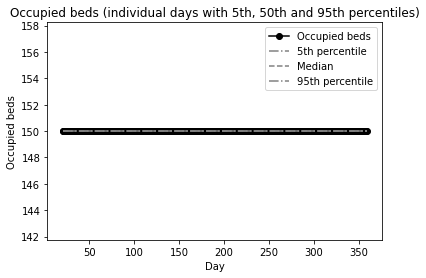

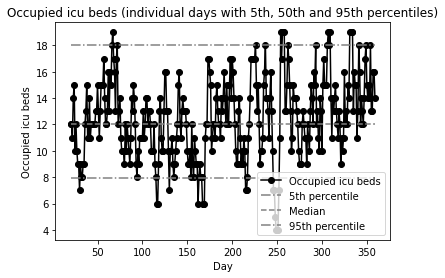

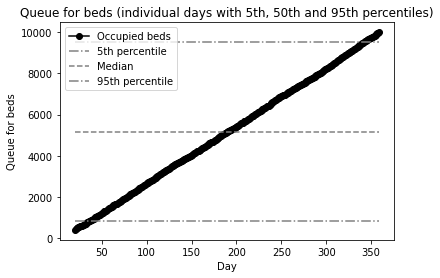

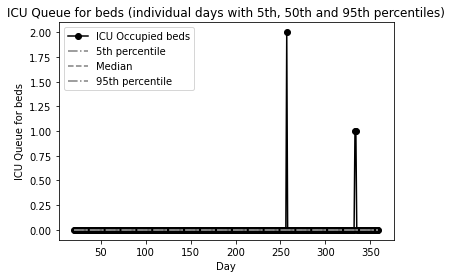

In [514]:
model.hospital.chart()